In [ ]:
import pandas as pd
import requests
from tqdm import tqdm_notebook
import time

Чтобы получить токен-доступ нужено перейти по ссылке:
https://oauth.vk.com/authorize?client_id=51951712&scope=8192&redirect_uri=https://oauth.vk.com/blank.html&display=page&v=5.16&response_type=token

Копируем то, что в адресной строке между "https://oauth.vk.com/blank.html#access_token=" и "&expires_in=". Токен выглядит как "vk1. ...". Для безопасности своего аккаунта записываем в  текстовый файл с именем 'token.txt' , не вставляем напрямую в python блокнот.

client_id=51951712 - id созданного пользоватльского приложения в ВК
'8192' в ссылке ниже кодирует необходимые разрешения, взято из документации vk.api"

In [ ]:
version = '5.199' #использовавшаяся версия vk api

#открытие файла с токеном доступа, нужно запускать если будет заново осуществляться парсинг
#with open('token.txt') as f:
#    token = f.read()
token = ''#оставим пустым пока не делаем парсинг повторно

## Цель работы
Исследовать , как поколение Зумеров взаимдействуетс большим Театром. Выявить через комментарии в группе в ВК чему Зумеры уделяют внимание, что им нравится, а что нет. Провести гендерный анализ активности зумеров в комментариях сообщества.
Сравнить отношения Зумеров с Большим Театром с предшествующим поколением миллениалов.

## Соберём в единый датафрейм все посты в группе ВК Большого театра
Для того, чтобы начать аналищировать тексты комментариев, сначала соберём id всех постов в группе. После будем рассматривать коммментарии, оставленные к каждому посту.

In [ ]:
group_id = '-52257710'

In [ ]:
def vk_download(method, parameters):
    url = 'https://api.vk.com/method/' + method + \
          '?' + parameters + '&v=' + version + '&access_token=' + token
    response = requests.get(url)
    return response.json()

In [ ]:
from tqdm import tqdm #Для того, чтобы отслеживать число выполненных итераций цикла

В следующей ячейка производится сбор id, текстов и лайков всех постов в группе ВК Большого театра. Нам наиболее интересны id постов. Мы будем использовать их для того, чтобы собрать датасет из комментариев к постам.

Сбор данных и их обрабоотка занимают много времени, поэтому следующая ячейка переведена в формат "Raw", а результат парсинга постов открыт из ранее сохранённого файла. Аналогично для других времязатрытных ячеек в этом блокноте. При необходимости ячейку можно перевести в Code формат и провести вычисленияю

## Имея id постов мы можем собрать все комментарии при помощи метода 'wall.getComments'

In [ ]:
# Присоединяем свой гугл диск, куда загружены файлы
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gdown
from gdown import download
import pandas as pd

In [ ]:
from gdown import download

# Скачиваем файлы с Google Диска
download('https://drive.google.com/uc?id=1T3INxRtvIGvkBjYh9O95L7kxNkGbkjL6', output='wall_data.pkl')
download('https://drive.google.com/uc?id=132WhhxD8oCY6CRPPu_UhzQvee1vCyQV4', output='zoomers_preproc.pkl')
download('https://drive.google.com/uc?id=1ywI9sQ5ZFNTt2sGpDUaikraKr6_DdMfV', output='zoomers_sentiment.pkl')
download('https://drive.google.com/uc?id=1aHNUbHtPnd5YoCJ7u94iyF5Ukm1wE_aR', output='millenials_sentiment.pkl')
download('https://drive.google.com/uc?id=1DADRNSHda34FhIhNMipj_aP_asKPytFO', output='millenials_preproc.pkl')
download('https://drive.google.com/uc?id=1S-gO0Z3wj6823Ev_k0P697Y-zLdLNY87', output='data_zoomers.pkl')
download('https://drive.google.com/uc?id=1Ult5JYKqYzIgHPyMVUjIxTbpy3kSE5iB', output='data_millenials.pkl')
download('https://drive.google.com/uc?id=1ExiKv_I-Stiwr2DVhIHw5lTF__b3DlC1', output='data_comments.pkl')
download('https://drive.google.com/uc?id=1OMAXaa9StE5IqWzMfLfrZw_Kc-FaA10p', output='zoomer_vocab.pkl')

# Теперь все файлы должны быть доступны в вашей рабочей директории в Colab

Downloading...
From: https://drive.google.com/uc?id=1T3INxRtvIGvkBjYh9O95L7kxNkGbkjL6
To: /content/wall_data.pkl
100%|██████████| 7.60M/7.60M [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=132WhhxD8oCY6CRPPu_UhzQvee1vCyQV4
To: /content/zoomers_preproc.pkl
100%|██████████| 152k/152k [00:00<00:00, 39.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ywI9sQ5ZFNTt2sGpDUaikraKr6_DdMfV
To: /content/zoomers_sentiment.pkl
100%|██████████| 151k/151k [00:00<00:00, 35.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aHNUbHtPnd5YoCJ7u94iyF5Ukm1wE_aR
To: /content/millenials_sentiment.pkl
100%|██████████| 152k/152k [00:00<00:00, 55.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DADRNSHda34FhIhNMipj_aP_asKPytFO
To: /content/millenials_preproc.pkl
100%|██████████| 157k/157k [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S-gO0Z3wj6823Ev_k0P697Y-zLdLNY87
To: /content/data_zoomers.pkl
100%|██████████| 434k/434k [0

'zoomer_vocab.pkl'

In [ ]:
df = pd.read_pickle('wall_data.pkl')
df

,id,text,likes
0,38676,«Дон Жуан» — 21–23 июня на Новой сцене\n\nГени...,"{'can_like': 0, 'count': 43, 'user_likes': 0}"
1,38648,"Сегодня, 16 июня, день рождения празднует Худо...","{'can_like': 0, 'count': 218, 'user_likes': 0}"
2,38614,Умер Игорь Меркулов\n\nНа 62-м году жизни скор...,"{'can_like': 0, 'count': 345, 'user_likes': 0}"
3,38594,🎉Большой театр завершил гастроли в Уфе\n\n14 и...,"{'can_like': 0, 'count': 107, 'user_likes': 0}"
4,38556,"Сегодня, 15 июня, день рождения празднует заве...","{'can_like': 0, 'count': 224, 'user_likes': 0}"
...,...,...,...
4235,9,Финалисты конкурса с Юрием Григоровичем и Свет...,"{'can_like': 0, 'count': 0, 'user_likes': 0}"
4236,8,Москва. 13 марта. INTERFAX.RU - Председатель п...,"{'can_like': 0, 'count': 0, 'user_likes': 0}"
4237,7,Народный артист СССР Борис Акимов возглавил ху...,"{'can_like': 0, 'count': 0, 'user_likes': 0}"
4238,6,National Artist of the USSR Boris Akimov heads...,"{'can_like': 0, 'count': 0, 'user_likes': 0}"


In [ ]:
def comments_download(method, parameters):
    url = 'https://api.vk.com/method/' + method + \
          '?' + parameters + '&v=' + version + '&access_token=' + token
    response = requests.get(url)
    return response.json()

In [ ]:
df = pd.read_pickle('data_comments.pkl')
df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date
0,38648,-52257710,228348050,"Почему на сайте невозможно зарегистрироваться,...",1,23.1,"{'id': 1000215, 'title': 'Kirov (khutor)'}",16.06.2024
1,38648,-52257710,407268163,Поздравляем настоящего мужчину и замечательног...,1,3.1,"{'id': 20558, 'title': 'Dzerzhinsky'}",16.06.2024
2,38648,-52257710,358485112,"Мои поздравления,Махару!Удачи,здоровья и настр...",1,unknown,unknown,16.06.2024
3,38648,-52257710,35276033,С Днём рождения),1,4.8,"{'id': 1, 'title': 'Moscow'}",16.06.2024
4,38648,-52257710,695364277,Примите самые искренние поздравления! Процвета...,1,18.1,"{'id': 1, 'title': 'Moscow'}",16.06.2024
...,...,...,...,...,...,...,...,...
12062,996,-52257710,23957278,очень интересно смотрится и шикарно слушается....,1,unknown,"{'id': 60, 'title': 'Kazan'}",06.04.2015
12063,962,-52257710,317936682,комментим https://www.youtube.com/watch?v=ov-n...,1,26.4,"{'id': 1, 'title': 'Moscow'}",25.04.2016
12064,948,-52257710,30294033,Почему-то в Пскове в кинотеатрах не показывают...,1,26.5.1998,"{'id': 2, 'title': 'Saint Petersburg'}",11.05.2015
12065,256,-52257710,657861837,1странная смерть - заражение крови после опера...,2,11.3.1937,"{'id': 99, 'title': 'Novosibirsk'}",27.08.2021


Всего вышло 12 тысяч комментариев, нам предстоит выбрать подходящие и провести обработку их текста.

## Разведочный анализ

Построим гистограмму с числом комментариев от польщователей в зависимости от их года рождения. Как видно, для Миллениалов сщуественно больше данных. Следует также учитывать, что в ВК пользователи часто скрывают год рождения.

<ipython-input-44-477071e0a886>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['bdate'].dt.year


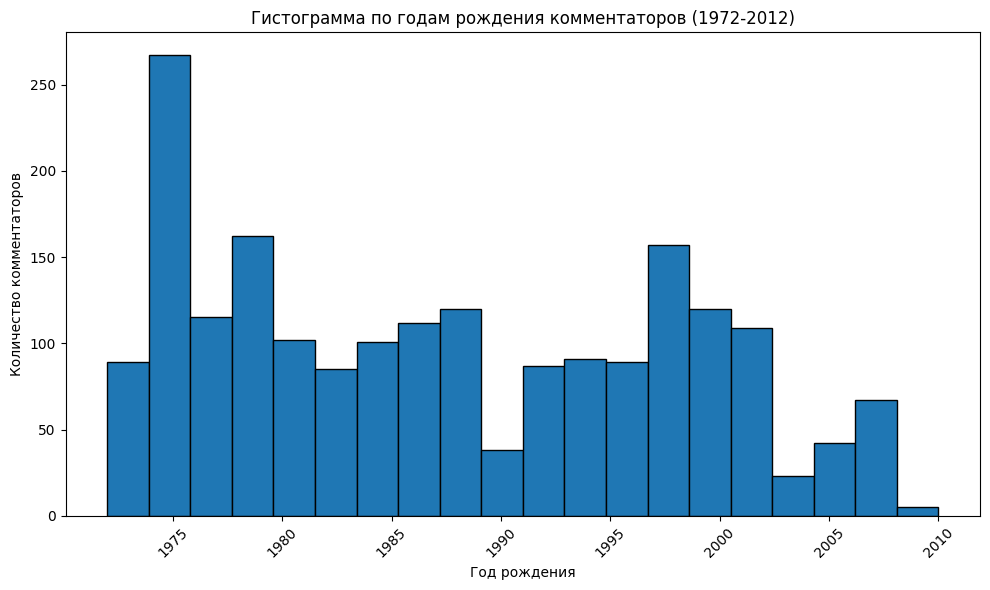

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['bdate'] = pd.to_datetime(df['bdate'], format='%d.%m.%Y', errors='coerce')  # Specify format

invalid_dates = df['bdate'].isnull()
if invalid_dates.any():
    df = df[~invalid_dates]


df.loc[:, 'year'] = df['bdate'].dt.year

df = df[(df['year'] >= 1972) & (df['year'] <= 2012)]
df.to_pickle('data_zoomers.pkl')

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['year'], bins=20, edgecolor='black')
plt.xlabel('Год рождения')
plt.ylabel('Количество комментаторов')
plt.title('Гистограмма по годам рождения комментаторов (1972-2012)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Так как мы занимаемся исследованием поколения Зумеров, нам не интересны посты пользователей, информация о дате рождения на странице которых закрыта или неполная(не указан год). Оставим в датафрейме комментарии только от людей, родившихся между 1997 и 2012. Сохраним результат в файл.

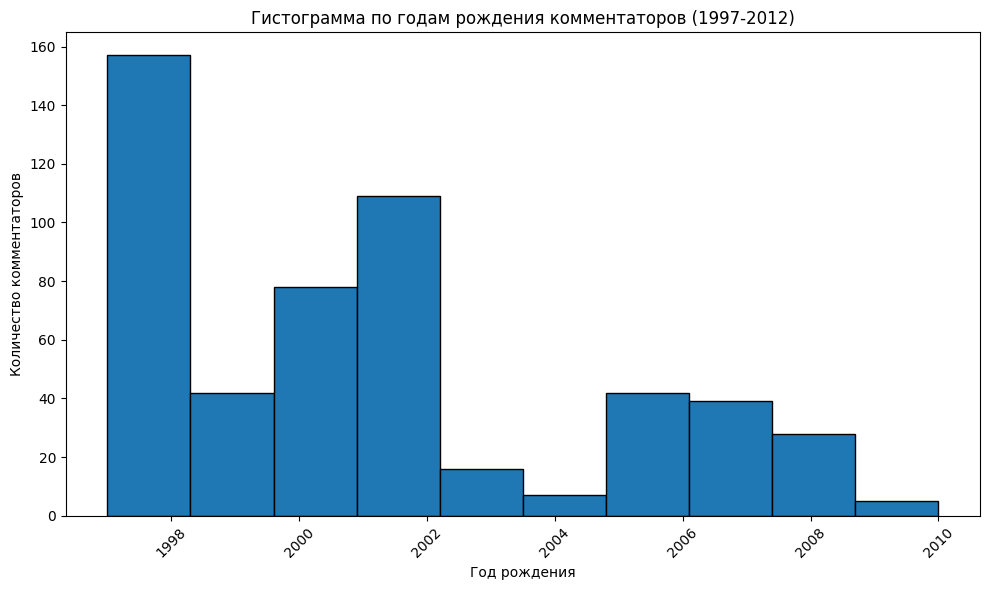

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
df['bdate'] = pd.to_datetime(df['bdate'], format='%d.%m.%Y', errors='coerce')  # Specify format

# Check for invalid dates (NaT)
invalid_dates = df['bdate'].isnull()
if invalid_dates.any():
    # Option 1: Remove invalid rows
    df = df[~invalid_dates]
    # Option 2: Try manual parsing if needed

# Extract year using .loc
df.loc[:, 'year'] = df['bdate'].dt.year

# Filter for years between 1997 and 2012
df = df[(df['year'] >= 1997) & (df['year'] <= 2012)]
df.to_pickle('data_zoomers.pkl')

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['year'], bins=10, edgecolor='black')
plt.xlabel('Год рождения')
plt.ylabel('Количество комментаторов')
plt.title('Гистограмма по годам рождения комментаторов (1997-2012)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Предобработка данных

Пришло время заняться самым интересным: обработать текст комментариев. Мы токенизируем текст, получим леммы слов, уберём стоп-слова.

In [ ]:
# Откроем полученный датафрейм с комментариями только от зумеров. Тексты комментариев подлежат обработке.
df = pd.read_pickle('data_zoomers.pkl')
df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year
30,38537,-52257710,378033642,"Настоящий спектакль-тот, который вызывает Ажио...",1,1998-06-12,unknown,15.06.2024,1998
54,38483,-52257710,10456275,Спасибо за вечер красоты. Браво🎉🎉🎉,1,1998-06-12,unknown,14.06.2024,1998
59,38481,-52257710,60741434,Теперь с нетерпением ждём Мариинскую версию «К...,2,1998-12-26,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1998
69,38463,-52257710,309460721,Добрый вечер. Уже 40 минут пытаюсь купить биле...,1,2005-09-28,unknown,16.06.2024,2005
72,38440,-52257710,32447368,Спектакль 13 числа незабываем. 4 часа промчали...,1,1998-06-12,unknown,15.06.2024,1998
...,...,...,...,...,...,...,...,...,...
11838,2151,-52257710,139223803,,1,2003-10-26,"{'id': 1, 'title': 'Moscow'}",16.10.2015,2003
11913,1775,-52257710,301405385,"[id45486217|Рома], спасибо",1,2001-07-20,"{'id': 650, 'title': 'Dnipro (Dnipropetrovsk)'}",22.07.2015,2001
11972,1413,-52257710,305642671,крута,1,1999-11-03,"{'id': 1, 'title': 'Moscow'}",19.05.2015,1999
11977,1401,-52257710,232897575,я тоже,2,2002-01-14,"{'id': 8341, 'title': 'Kichmengsky Gorodok'}",11.05.2015,2002


In [ ]:
from transformers import pipeline  # Импортируем pipeline для работы с предобученными моделями transformers
import nltk  # Импортируем nltk для работы с обработкой естественного языка
import re  # Импортируем re для работы с регулярными выражениями

nltk.download("stopwords")  # Скачиваем набор стоп-слов
nltk.download('punkt')  # Скачиваем токенизатор nltk.word_tokenize

from nltk.corpus import stopwords  # Импортируем набор стоп-слов из nltk
stop_words = stopwords.words("russian")  # Загружаем список стоп-слов для русского языка
from pymystem3 import Mystem  # Импортируем Mystem для морфологического анализа
m = Mystem()   # Создаем объект Mystem

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
import pickle

# Во время выполнения программы был составлен словарь сопоставляющий встречающимся словам их Лемму. Это позволяет скорять лемматизацию теекста.
#Словарь - ценный набор данных, в конце блокнота он был сохранён ,чтобы можноб было его использовать при продолжении исследования.
with open('zoomer_vocab.pkl', 'rb') as f:
    zoomer_vocab = pickle.load(f)


#Если программа запускается в первый раз, то следует инициализировать словарь следующим образом:
#zoomer_vocab = {}

In [ ]:
import pymystem3  # Импорт библиотеки для морфологического анализа

analyzer = pymystem3.Mystem()  # Создание объекта анализатора

def my_preproc(text):  # Функция для предобработки текста
    return_list = []  # Список для хранения обработанных слов

    text = re.sub('https?://[^,s]+,?', ' ', text)  # Удаление ссылок
    text = re.sub('[^a-zа-я]+', ' ', text.lower())  # Удаление ненужных символов, перевод в нижний регистр

    for i in text.split():  # Итерируем по словам в тексте
        if len(i) > 1:  # Проверка длины слова
            if i in zoomer_vocab:  # Проверка наличия слова в словаре зумеров
                return_list.append(zoomer_vocab[i])  # Добавление нормальной формы из словаря
            else:
                norm_form = analyzer.lemmatize(i)[0]  # Получение нормальной формы слова
                if norm_form not in stop_words:  # Проверка на стоп-слово
                    zoomer_vocab[i] = norm_form  # Добавление слова в словарь зумеров
                    return_list.append(norm_form)  # Добавление нормальной формы в список
                else:
                    continue  # Пропуск стоп-слов
    return return_list  # Возвращение списка обработанных слов

In [ ]:
# Для удобства работы был создан новый датафрейм, являющийся копией основного
new_df = df.copy()
new_df = new_df.reset_index(drop=True)  # Сброс индексов в новом датафрейме. Так удобнее будет с ним работать.
new_df['text_preproc'] = '0'  # Добавление нового столбца 'text_preproc' с начальным значением '0'. Эт опонадобится нам позднее
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc
0,38537,-52257710,378033642,"Настоящий спектакль-тот, который вызывает Ажио...",1,1998-06-12,unknown,15.06.2024,1998,0
1,38483,-52257710,10456275,Спасибо за вечер красоты. Браво🎉🎉🎉,1,1998-06-12,unknown,14.06.2024,1998,0
2,38481,-52257710,60741434,Теперь с нетерпением ждём Мариинскую версию «К...,2,1998-12-26,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1998,0
3,38463,-52257710,309460721,Добрый вечер. Уже 40 минут пытаюсь купить биле...,1,2005-09-28,unknown,16.06.2024,2005,0
4,38440,-52257710,32447368,Спектакль 13 числа незабываем. 4 часа промчали...,1,1998-06-12,unknown,15.06.2024,1998,0
...,...,...,...,...,...,...,...,...,...,...
518,2151,-52257710,139223803,,1,2003-10-26,"{'id': 1, 'title': 'Moscow'}",16.10.2015,2003,0
519,1775,-52257710,301405385,"[id45486217|Рома], спасибо",1,2001-07-20,"{'id': 650, 'title': 'Dnipro (Dnipropetrovsk)'}",22.07.2015,2001,0
520,1413,-52257710,305642671,крута,1,1999-11-03,"{'id': 1, 'title': 'Moscow'}",19.05.2015,1999,0
521,1401,-52257710,232897575,я тоже,2,2002-01-14,"{'id': 8341, 'title': 'Kichmengsky Gorodok'}",11.05.2015,2002,0


new_df = new_df[new_df['text_preproc'].apply(lambda x: x != [])]
new_df = new_df.reset_index(drop=True)
new_df.to_pickle('zoomers_preproc.pkl')
new_df

In [ ]:
new_df = pd.read_pickle('zoomers_preproc.pkl')
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc,sentiment
0,38508,-52257710,2069244,"Настя, ты умница, мои поздравления!",1,1986-08-24,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1986,"[настя, умница, поздравление]",NEGATIVE
1,38440,-52257710,132061621,Огромная благодарность за спектакль! Четыре ча...,1,1987-02-04,unknown,14.06.2024,1987,"[огромный, благодарность, спектакль, четыре, ч...",NEGATIVE
2,38360,-52257710,766806364,Поздравляю! 👏,1,1989-04-03,"{'id': 3791992, 'title': 'Shijiazhuang'}",10.06.2024,1989,[поздравлять],NEUTRAL
3,38188,-52257710,141735699,"Добрый День! Скажите, пожалуйста , когда объяв...",2,1988-01-01,"{'id': 1, 'title': 'Moscow'}",03.06.2024,1988,"[добрый, день, сказать, пожалуйста, объявлять,...",NEUTRAL
4,38117,-52257710,25184875,Спасибо! Это было потрясающе!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",30.05.2024,1989,"[спасибо, это, потрясающе]",POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...
437,14122,-52257710,10653609,"Сцена ""Аутодафе"" из Дона Карлоса в Большом, эт...",1,1986-09-09,"{'id': 397, 'title': 'Stupino'}",10.09.2020,1986,"[сцена, аутодафе, дон, карлос, большой, это, х...",NEUTRAL
438,14112,-52257710,593840617,Спасибо!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",04.09.2020,1989,[спасибо],POSITIVE
439,14061,-52257710,3183345,"Соболезнования родным, близким и друзьям.",1,1985-07-08,"{'id': 472, 'title': 'Kostomuksha'}",25.08.2020,1985,"[соболезнование, родной, близкий, друг]",NEGATIVE
440,14034,-52257710,500911594,"С Днём Рождения, Екатерина !",1,1996-06-05,"{'id': 1, 'title': 'Moscow'}",22.08.2020,1996,"[дн, рождение, екатерина]",NEUTRAL


In [ ]:
from transformers import pipeline  # Импорт функции pipeline из библиотеки transformers для работы с предобученными моделями машинного обучения,
# в данном случае для сентиментального анализа.

In [ ]:
# Загружаем предобученную модель
# Выбор модели обусловлен тем, что она предназначена для сентиментального анализа коротких тексов на русском языке
# Разделение сентимента на 3 случая: позитивный, негативный и нейтральный
# Кроме того, она уже использовалась на семинаре и опыт работы с ней был
classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

# Проводим сентимент-анализ, Для проведение анализа нужно раскоментировать строку ниже
#new_df['sentiment'] = new_df['text_preproc'].apply(lambda text: classifier(text)[0]['label'])

# Сохраним результат сентимент анализа в файле
#new_df.to_pickle('zoomers_sentiment.pkl')

model.safetensors:  93%|#########2| 661M/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
new_df = pd.read_pickle('zoomers_sentiment.pkl')
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc,sentiment
0,38537,-52257710,378033642,"Настоящий спектакль-тот, который вызывает Ажио...",1,1998-06-12,unknown,15.06.2024,1998,"[настоящий, спектакль, который, вызывать, ажио...",POSITIVE
1,38483,-52257710,10456275,Спасибо за вечер красоты. Браво🎉🎉🎉,1,1998-06-12,unknown,14.06.2024,1998,"[спасибо, вечер, красота, браво]",POSITIVE
2,38481,-52257710,60741434,Теперь с нетерпением ждём Мариинскую версию «К...,2,1998-12-26,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1998,"[нетерпение, жд, мариинский, версия, корсар, ш...",NEUTRAL
3,38463,-52257710,309460721,Добрый вечер. Уже 40 минут пытаюсь купить биле...,1,2005-09-28,unknown,16.06.2024,2005,"[добрый, вечер, минута, пытаться, купить, биле...",NEUTRAL
4,38440,-52257710,32447368,Спектакль 13 числа незабываем. 4 часа промчали...,1,1998-06-12,unknown,15.06.2024,1998,"[спектакль, число, незабываемый, час, промчать...",NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...
423,2797,-52257710,14243161,Поздравляю!!!,1,2000-08-18,"{'id': 95, 'title': 'Nizhny Novgorod'}",22.01.2016,2000,[поздравлять],NEUTRAL
424,2313,-52257710,157562860,"Скажите, а на канале в youtube будет показ бал...",1,2000-08-18,"{'id': 95, 'title': 'Nizhny Novgorod'}",07.11.2015,2000,"[сказать, канал, youtube, показ, балет]",NEUTRAL
425,1775,-52257710,301405385,"[id45486217|Рома], спасибо",1,2001-07-20,"{'id': 650, 'title': 'Dnipro (Dnipropetrovsk)'}",22.07.2015,2001,"[id, рома, спасибо]",NEGATIVE
426,1413,-52257710,305642671,крута,1,1999-11-03,"{'id': 1, 'title': 'Moscow'}",19.05.2015,1999,[крутой],POSITIVE


## Визуализация результатов

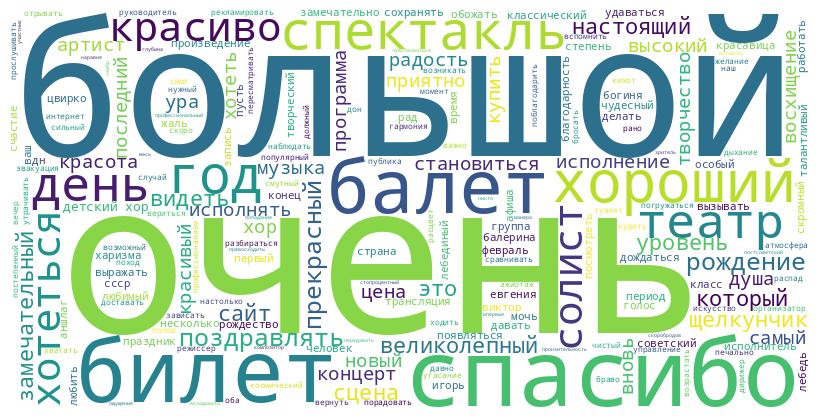

In [ ]:
positive_lem = []  # Создаем пустой список для хранения лемм из положительных отзывов

for i in range(len(new_df)):  # Итерируем по датафрейму
    if new_df['sentiment'][i] == 'POSITIVE':  # Проверяем, является ли отзыв положительным
        positive_lem.extend(new_df['text_preproc'][i])  # Добавляем леммы из положительного отзыва в список

positive_lem_str = ' '.join(positive_lem)  # Объединяем леммы в одну строку

from wordcloud import WordCloud  # Импортируем библиотеку для создания облака слов
import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков

# Сгенерируем облако слов
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_lem_str)  # Создаем объект облака слов

# Вывод облака слов на экран
plt.figure(figsize=(8, 8), facecolor=None)  # Создаем фигуру для графика
plt.imshow(wordcloud)  # Выводим облако слов на график
plt.axis("off")  # Убираем оси
plt.tight_layout(pad=0)  # Устраняем лишнее пространство вокруг графика
plt.show()  # Отображаем график

# Аналогично для нейтральных и негативных отзывов

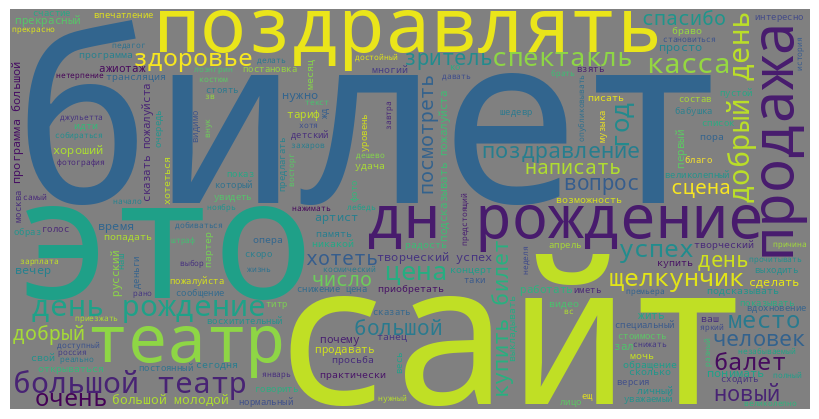

In [ ]:
neutral_lem = []

for i in range(len(new_df)):
    if new_df['sentiment'][i] == 'NEUTRAL':
        neutral_lem.extend(new_df['text_preproc'][i])

neutral_lem_str = ' '.join(neutral_lem)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="gray").generate(neutral_lem_str)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

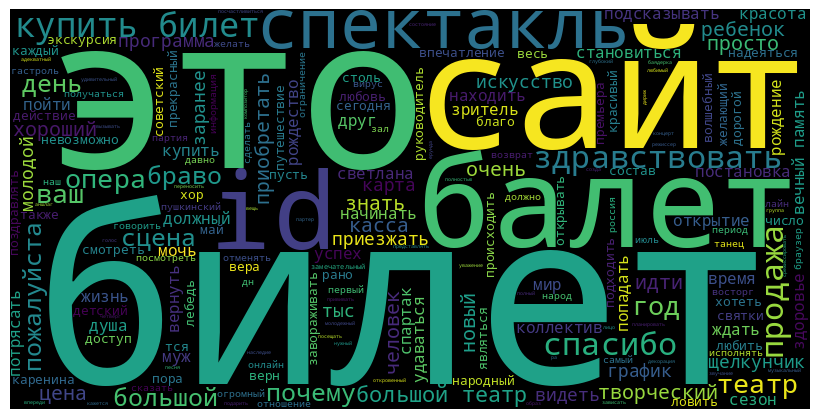

In [ ]:
negative_lem = []

for i in range(len(new_df)):
    if new_df['sentiment'][i] == 'NEGATIVE':
        negative_lem.extend(new_df['text_preproc'][i])

negative_lem_str = ' '.join(negative_lem)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_lem_str)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Облака слов в комментариях

Из трёх построенных выше облаков видно, что при в хороших коммментариях Зумеры говорят о постановках и хвалят большой театр. В случае Негативных и нейтральных комментарием упор делается на покупке билетов и сайте театра. Например, покупка билетов по студенческой скидке в момент старта акции  через несовременный сайт может оставить негативное впечатление.

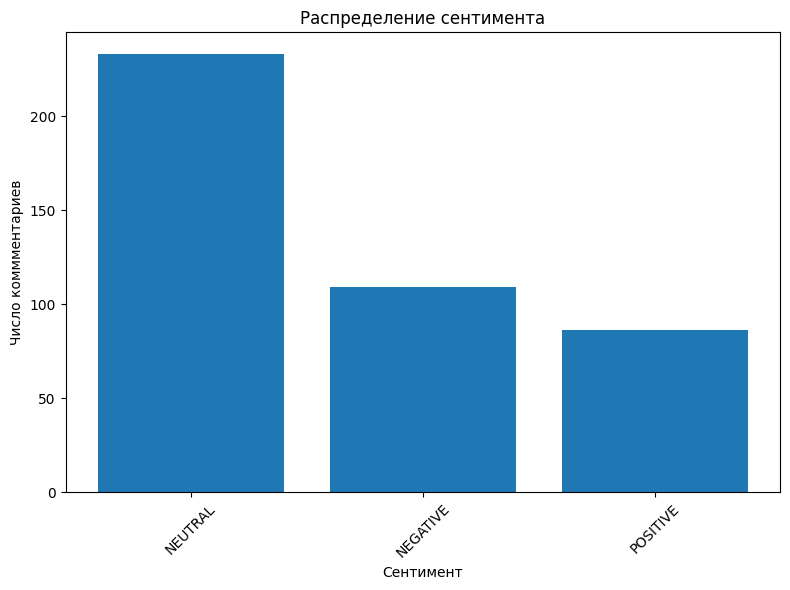

In [ ]:
#Этоу гистограмму мы впоследсвии сравним с Милениалами
new_df = pd.read_pickle('zoomers_sentiment.pkl')
new_df

import matplotlib.pyplot as plt  # Импорт библиотеки matplotlib для построения графиков

sentiment_counts = new_df['sentiment'].value_counts()  # Подсчет количества отзывов для каждого типа настроения

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Сентимент')
plt.ylabel('Число коммментариев')
plt.title('Распределение сентимента')
plt.xticks(rotation=45)  # Поворот подписей оси абсцисс на 45 градусов
plt.tight_layout()
plt.show()

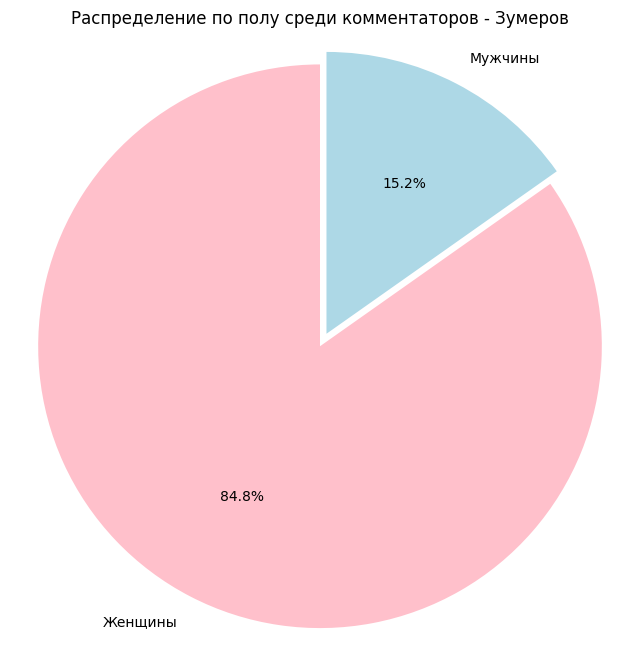

In [ ]:
import pandas as pd  # Импорт библиотеки pandas для работы с данными
import matplotlib.pyplot as plt  # Импорт библиотеки matplotlib для построения графиков

filtered_df = new_df[new_df['sex'] != 0]  # Фильтрация датафрейма, оставляя только строки для которых нам известен пол комментатора
sex_counts = filtered_df['sex'].value_counts()  # Подсчет количества мужчин и женщин в отфильтрованном датафрейме

labels = ['Женщины', 'Мужчины']  # Названия для секторов круговой диаграммы

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sex_counts.values,
    labels=labels,
    autopct="%1.1f%%",  # Отображение процентов на секторах с одним десятичным знаком
    startangle=90,
    colors=['pink', 'lightblue', ],  # Цвета для секторов
    explode=(0.05, 0) if len(labels) == 2 else [0] * len(labels)  # Выделение одного сектора диаграммы для лучшей визуализации
)

plt.title("Распределение по полу среди комментаторов - Зумеров")
plt.axis("equal")
plt.show()

## Сравнение проявления активности гендаров

Вмидно, что среди Зумеров женщины существенно активнее оставляют комментарии в сообществе.

## Получим для сравнения также данные для Милениалов
В качестве репрезентативной выборки милениалов рассматриваем людейродившихся в 1981 - 1996

In [ ]:
#Всё полностью аналогично случаю с зумерами
df = pd.read_pickle('data_comments.pkl')
df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date
0,38648,-52257710,228348050,"Почему на сайте невозможно зарегистрироваться,...",1,23.1,"{'id': 1000215, 'title': 'Kirov (khutor)'}",16.06.2024
1,38648,-52257710,407268163,Поздравляем настоящего мужчину и замечательног...,1,3.1,"{'id': 20558, 'title': 'Dzerzhinsky'}",16.06.2024
2,38648,-52257710,358485112,"Мои поздравления,Махару!Удачи,здоровья и настр...",1,unknown,unknown,16.06.2024
3,38648,-52257710,35276033,С Днём рождения),1,4.8,"{'id': 1, 'title': 'Moscow'}",16.06.2024
4,38648,-52257710,695364277,Примите самые искренние поздравления! Процвета...,1,18.1,"{'id': 1, 'title': 'Moscow'}",16.06.2024
...,...,...,...,...,...,...,...,...
12062,996,-52257710,23957278,очень интересно смотрится и шикарно слушается....,1,unknown,"{'id': 60, 'title': 'Kazan'}",06.04.2015
12063,962,-52257710,317936682,комментим https://www.youtube.com/watch?v=ov-n...,1,26.4,"{'id': 1, 'title': 'Moscow'}",25.04.2016
12064,948,-52257710,30294033,Почему-то в Пскове в кинотеатрах не показывают...,1,26.5.1998,"{'id': 2, 'title': 'Saint Petersburg'}",11.05.2015
12065,256,-52257710,657861837,1странная смерть - заражение крови после опера...,2,11.3.1937,"{'id': 99, 'title': 'Novosibirsk'}",27.08.2021


<ipython-input-68-92b877ca3f3d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['bdate'].dt.year


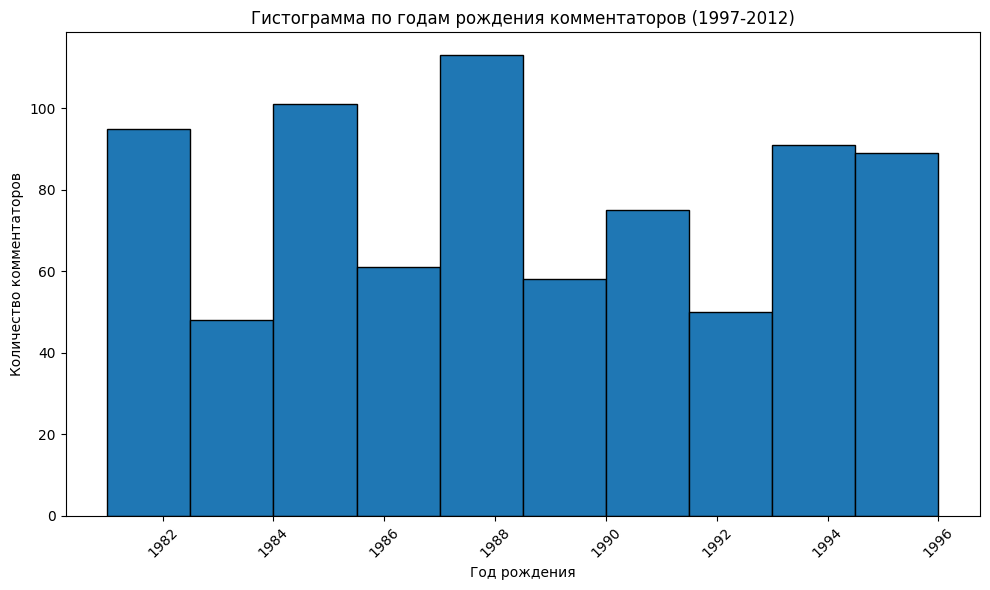

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['bdate'] = pd.to_datetime(df['bdate'], format='%d.%m.%Y', errors='coerce')  # Specify format

invalid_dates = df['bdate'].isnull()
if invalid_dates.any():
    df = df[~invalid_dates]

df.loc[:, 'year'] = df['bdate'].dt.year

df = df[(df['year'] >= 1981) & (df['year'] <= 1996)]
df.to_pickle('data_millenials.pkl')

plt.figure(figsize=(10, 6))
plt.hist(df['year'], bins=10, edgecolor='black')
plt.xlabel('Год рождения')
plt.ylabel('Количество комментаторов')
plt.title('Гистограмма по годам рождения комментаторов (1997-2012)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_pickle('data_millenials.pkl')
df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year
6,38648,-52257710,133277970,,2,1981-02-01,"{'id': 1, 'title': 'Moscow'}",17.06.2024,1981
38,38508,-52257710,424213551,За что???,2,1985-09-19,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1985
43,38508,-52257710,2069244,"Настя, ты умница, мои поздравления!",1,1986-08-24,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1986
71,38440,-52257710,132061621,Огромная благодарность за спектакль! Четыре ча...,1,1987-02-04,unknown,14.06.2024,1987
102,38360,-52257710,766806364,Поздравляю! 👏,1,1989-04-03,"{'id': 3791992, 'title': 'Shijiazhuang'}",10.06.2024,1989
...,...,...,...,...,...,...,...,...,...
11943,1608,-52257710,100510792,"[id176360527|Александр], и пиковую даму 1944 г...",2,1992-06-16,"{'id': 1970519, 'title': 'Dresden'}",22.06.2015,1992
11958,1458,-52257710,168014039,а что же нет билетов в продаже?,2,1992-06-16,"{'id': 1970519, 'title': 'Dresden'}",22.05.2015,1992
12008,1279,-52257710,5389311,В Италии не могу посмотреть(((,1,1982-01-28,unknown,19.04.2015,1982
12024,1267,-52257710,96075896,С дНЁМ РОЖДЕНИЯ,1,1982-01-15,"{'id': 177, 'title': 'Vyborg'}",18.04.2015,1982


In [ ]:
df = df.head(523) #Комментариев от Милениалов существенно больше, чем от зумером.
# Чтобы уменьшить время вычислений програмы ограничимся 523 комментариями Миллениалов.

In [ ]:
new_df = df.copy()
new_df = new_df.reset_index(drop=True)
new_df['text_preproc'] = '0'
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc
0,38648,-52257710,133277970,,2,1981-02-01,"{'id': 1, 'title': 'Moscow'}",17.06.2024,1981,0
1,38508,-52257710,424213551,За что???,2,1985-09-19,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1985,0
2,38508,-52257710,2069244,"Настя, ты умница, мои поздравления!",1,1986-08-24,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1986,0
3,38440,-52257710,132061621,Огромная благодарность за спектакль! Четыре ча...,1,1987-02-04,unknown,14.06.2024,1987,0
4,38360,-52257710,766806364,Поздравляю! 👏,1,1989-04-03,"{'id': 3791992, 'title': 'Shijiazhuang'}",10.06.2024,1989,0
...,...,...,...,...,...,...,...,...,...,...
518,14112,-52257710,593840617,Спасибо!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",04.09.2020,1989,0
519,14061,-52257710,3183345,"Соболезнования родным, близким и друзьям.",1,1985-07-08,"{'id': 472, 'title': 'Kostomuksha'}",25.08.2020,1985,0
520,14061,-52257710,133277970,,2,1981-02-01,"{'id': 1, 'title': 'Moscow'}",26.08.2020,1981,0
521,14034,-52257710,500911594,"С Днём Рождения, Екатерина !",1,1996-06-05,"{'id': 1, 'title': 'Moscow'}",22.08.2020,1996,0


In [ ]:
new_df = pd.read_pickle('millenials_preproc.pkl')
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc
0,38648,-52257710,133277970,,2,1981-02-01,"{'id': 1, 'title': 'Moscow'}",17.06.2024,1981,[]
1,38508,-52257710,424213551,За что???,2,1985-09-19,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1985,[]
2,38508,-52257710,2069244,"Настя, ты умница, мои поздравления!",1,1986-08-24,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1986,"[настя, умница, поздравление]"
3,38440,-52257710,132061621,Огромная благодарность за спектакль! Четыре ча...,1,1987-02-04,unknown,14.06.2024,1987,"[огромный, благодарность, спектакль, четыре, ч..."
4,38360,-52257710,766806364,Поздравляю! 👏,1,1989-04-03,"{'id': 3791992, 'title': 'Shijiazhuang'}",10.06.2024,1989,[поздравлять]
...,...,...,...,...,...,...,...,...,...,...
518,14112,-52257710,593840617,Спасибо!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",04.09.2020,1989,[спасибо]
519,14061,-52257710,3183345,"Соболезнования родным, близким и друзьям.",1,1985-07-08,"{'id': 472, 'title': 'Kostomuksha'}",25.08.2020,1985,"[соболезнование, родной, близкий, друг]"
520,14061,-52257710,133277970,,2,1981-02-01,"{'id': 1, 'title': 'Moscow'}",26.08.2020,1981,[]
521,14034,-52257710,500911594,"С Днём Рождения, Екатерина !",1,1996-06-05,"{'id': 1, 'title': 'Moscow'}",22.08.2020,1996,"[дн, рождение, екатерина]"


In [ ]:
new_df = new_df[new_df['text_preproc'].apply(lambda x: x != [])]
new_df = new_df.reset_index(drop=True)
#new_df.to_pickle('millenials_preproc.pkl')
#new_df

In [ ]:

#import PIL
from transformers import pipeline # Импорт функции pipeline


#Закомментировано, чтобы долго не считалось при проверке

#classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")
#new_df['sentiment'] = new_df['text_preproc'].apply(lambda text: classifier(text)[0]['label'])
#new_df.to_pickle('millenials_sentiment.pkl')
#new_df

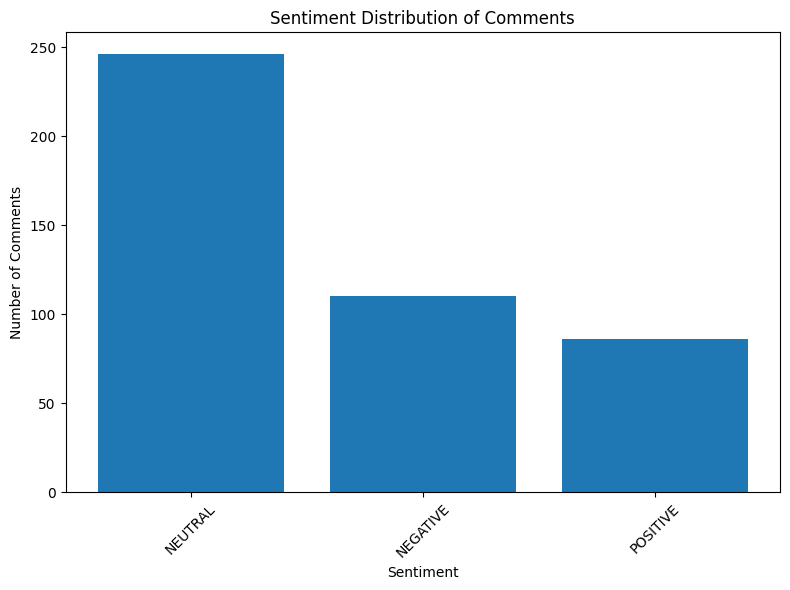

In [ ]:
new_df = pd.read_pickle('millenials_sentiment.pkl')
new_df

import matplotlib.pyplot as plt

sentiment_counts = new_df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Сохраним полученный в ходе работы с текстом словарь, чтобы потом с текстами можнобыло работать быстрее
#import pickle
#with open('zoomer_vocab.pkl', 'wb') as f:
#    pickle.dump(zoomer_vocab, f)

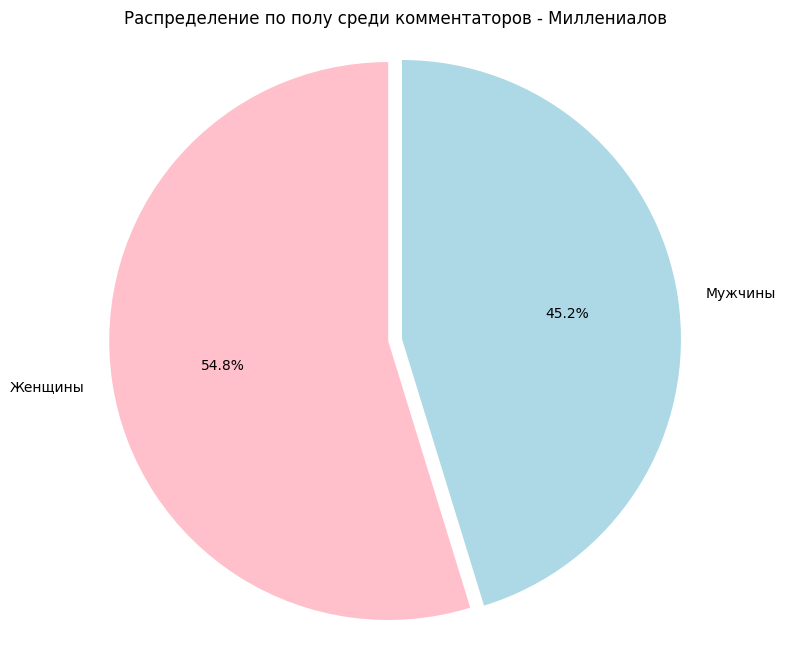

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_df = new_df[new_df['sex'] != 0]  # Фильтрация датафрейма, оставляя только строки для которых нам известен пол комментатора
sex_counts = filtered_df['sex'].value_counts()  # Подсчет количества мужчин и женщин в отфильтрованном датафрейме

labels = ['Женщины', 'Мужчины']  # Названия для секторов круговой диаграммы

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sex_counts.values,
    labels=labels,
    autopct="%1.1f%%",  # Отображение процентов на секторах с одним десятичным знаком
    startangle=90,
    colors=['pink', 'lightblue', ],  # Цвета для секторов
    explode=(0.05, 0) if len(labels) == 2 else [0] * len(labels)  # Выделение одного сектора диаграммы для лучшей визуализации
)

plt.title("Распределение по полу среди комментаторов - Миллениалов")
plt.axis("equal")
plt.show()

## Сравнение проявления активности гендаров
В отличие от Зумеров, среди Миллениалов различие  в активности мужчин и женщин в комментариях на странице сообщества невелико. Видно, что мужчины-Миллениалы существенно больше интересуются Большим театром, чем мужчины-Зумеры.

In [ ]:
new_df = new_df[new_df['text_preproc'].apply(lambda x: x != [])]
new_df = new_df.reset_index(drop=True)
new_df.to_pickle('zoomers_preproc.pkl')
new_df

,post_id,owner_id,from_id,text,sex,bdate,city,comment_date,year,text_preproc,sentiment
0,38508,-52257710,2069244,"Настя, ты умница, мои поздравления!",1,1986-08-24,"{'id': 1, 'title': 'Moscow'}",14.06.2024,1986,"[настя, умница, поздравление]",NEGATIVE
1,38440,-52257710,132061621,Огромная благодарность за спектакль! Четыре ча...,1,1987-02-04,unknown,14.06.2024,1987,"[огромный, благодарность, спектакль, четыре, ч...",NEGATIVE
2,38360,-52257710,766806364,Поздравляю! 👏,1,1989-04-03,"{'id': 3791992, 'title': 'Shijiazhuang'}",10.06.2024,1989,[поздравлять],NEUTRAL
3,38188,-52257710,141735699,"Добрый День! Скажите, пожалуйста , когда объяв...",2,1988-01-01,"{'id': 1, 'title': 'Moscow'}",03.06.2024,1988,"[добрый, день, сказать, пожалуйста, объявлять,...",NEUTRAL
4,38117,-52257710,25184875,Спасибо! Это было потрясающе!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",30.05.2024,1989,"[спасибо, это, потрясающе]",POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...
437,14122,-52257710,10653609,"Сцена ""Аутодафе"" из Дона Карлоса в Большом, эт...",1,1986-09-09,"{'id': 397, 'title': 'Stupino'}",10.09.2020,1986,"[сцена, аутодафе, дон, карлос, большой, это, х...",NEUTRAL
438,14112,-52257710,593840617,Спасибо!,1,1989-11-20,"{'id': 61, 'title': 'Kaliningrad'}",04.09.2020,1989,[спасибо],POSITIVE
439,14061,-52257710,3183345,"Соболезнования родным, близким и друзьям.",1,1985-07-08,"{'id': 472, 'title': 'Kostomuksha'}",25.08.2020,1985,"[соболезнование, родной, близкий, друг]",NEGATIVE
440,14034,-52257710,500911594,"С Днём Рождения, Екатерина !",1,1996-06-05,"{'id': 1, 'title': 'Moscow'}",22.08.2020,1996,"[дн, рождение, екатерина]",NEUTRAL


In [ ]:
# Загрузка данных
zoomers_df = pd.read_pickle('/content/drive/MyDrive/bolshoi/zoomers_sentiment.pkl')
millennials_df = pd.read_pickle('/content/drive/MyDrive/bolshoi/millenials_sentiment.pkl')

# Подсчет количества отзывов для каждого типа настроения
zoomers_counts = zoomers_df['sentiment'].value_counts()
millennials_counts = millennials_df['sentiment'].value_counts()

# Нормализация данных
zoomers_counts_norm = zoomers_counts / zoomers_counts.sum()
millennials_counts_norm = millennials_counts / millennials_counts.sum()

# Создание гистограммы
fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма для зумеров (нормализованная)
ax.bar(zoomers_counts_norm.index, zoomers_counts_norm.values, label='Зумеры', color='blue', alpha=0.6)

# Гистограмма для миллениалов (нормализованная)
ax.bar(millennials_counts_norm.index, millennials_counts_norm.values, label='Миллениалы', color='red', alpha=0.6)

# Настройка графика
ax.set_xlabel('Сентимент')
ax.set_ylabel('Доля комментариев')  # Изменяем подпись оси Y
ax.set_title('Распределение сентимента среди зумеров и миллениалов (нормализованное)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Сравнение сентиментов для Зумеров и Миллениалов
Видим, что распределение сентимента среди Зумеров и Миллениалов практически совпадают. Значит, Зумеры и Миллениалы схожим образом реагируют на новости о Большом театре и разницы между двумя поколениями в этом вопросе не наблюдается. Подробнее об этом будет сказано в презентации.

# Выводы:

- Выявлено, что для Зумеров (в отличие от Миллениалов), существует сильный гендерный перекос по активности в компентариях в пользу женщин.
- Оставляя положительнве комментарии, Зумеры хвалят театр и делают акцент отдельно на балете, спектакле, красоте, самом театре. В негативных комментариях чаще всего встречаются слова "билет" и "сайт", вероятно, связанные с покупкой билетов через сайт. Видимо, что сайт театра недостаточно функциональный и имеет перебои в работе в моменты открытия продаж билетов по акции.
- Не выявлено разницы между соотношением положительных / нейтральных / негативных комментариев у Зумеров и у Миленниалов. Это говорит о том, что взаимодействуя с Большим театром предстваители разных поколений получают удовольствие и претерпевают неудобства в близких пропорциях.